In [42]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import seaborn as sns

In [43]:
df = pd.read_csv("dataset/train.csv")
df = df[df["px_height"] != 0]
df = df[df["px_width"] != 0]
df["total_pixels"] = df["px_height"] * df["px_width"]
df["screen_area"] = df["sc_h"] * df["sc_w"]
df["ppi"] = np.sqrt(df["px_height"]**2 + df["px_width"]**2) / 5.5
X = df.drop("price_range", axis=1)
y = df["price_range"]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# 1- SVM MODEL
# Hyperparameter Tuning (GridSearchCV ile)
# ek olarak burada da cross validation kullandım.
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=3)
grid.fit(X_train_scaled, y_train)

print("\nEn iyi hiperparametreler (GridSearchCV):")
print(grid.best_params_)
print("En iyi CV skoru (train üzeri 3-fold ortalama):", grid.best_score_)

# En iyi bulunan SVM modelini alalım
best_svm = grid.best_estimator_

# Train ve Test Üzerinde Performans (Overfitting kontrolü)
# train_acc ve test_acc birbirine yakınsa, belirgin overfitting yoktur)
train_pred = best_svm.predict(X_train_scaled)
test_pred = best_svm.predict(X_test_scaled)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("\nTrain accuracy:", train_acc)
print("Test accuracy:", test_acc)



En iyi hiperparametreler (GridSearchCV):
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
En iyi CV skoru (train üzeri 3-fold ortalama): 0.934919381004105

Train accuracy: 0.9718397997496871
Test accuracy: 0.9525


Başlangıçta SVM modelinin train ve test başarı oranları arasında belirgin bir fark vardı (Train: %98.4 – Test: %92.5). Bu durum modelin veriye fazla uyum sağladığını ve hafif overfitting oluştuğunu gösteriyordu. Overfitting’i azaltmak için önerilen adımlar sırasıyla uygulanmıştır. Özellikle 3. adım olan hiperparametre aralığının genişletilmesi (C ve gamma değerlerinin daha geniş bir grid üzerinde denenmesi) sonrası model daha dengeli bir hâle gelmiştir. Bu iyileştirmeyle birlikte modelin performansı Train: %97.18 ve Test: %95.25 değerlerine yükselmiş, train–test farkı yaklaşık %2 seviyesine düşerek overfitting büyük ölçüde azaltılmıştır. Bu sonuç, modelin artık veriyi ezberlemeden daha iyi genellediğini göstermektedir.

In [25]:
print("\nClassification Report (Test verisi):")
print(classification_report(y_test, test_pred))


Classification Report (Test verisi):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       100
           1       0.94      0.94      0.94       100
           2       0.94      0.91      0.92       100
           3       0.95      0.98      0.97       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [26]:
cm = confusion_matrix(y_test, test_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[98  2  0  0]
 [ 2 94  4  0]
 [ 0  4 91  5]
 [ 0  0  2 98]]


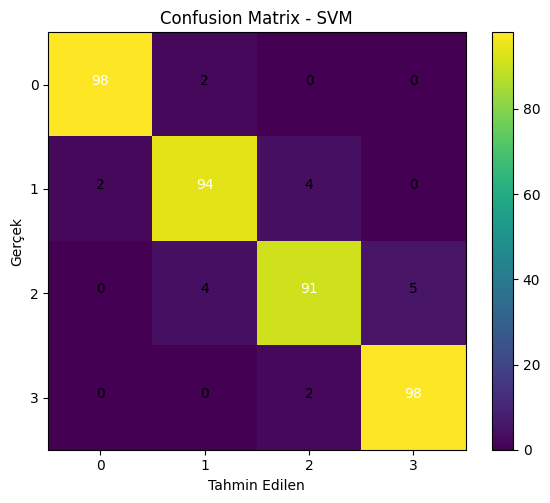

In [27]:
# Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - SVM")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

In [38]:
# 2- DECISION TREE MODEL
from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8]
}

dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(dt, param_grid_dt, cv=3, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

print("\n[Decision Tree] En iyi hiperparametreler (GridSearchCV):")
print(grid_dt.best_params_)
print("[Decision Tree] En iyi CV skoru (train üzeri 3-fold ortalama):", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

dt_train_pred = best_dt.predict(X_train)
dt_test_pred  = best_dt.predict(X_test)

dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc  = accuracy_score(y_test, dt_test_pred)

print("\n[Decision Tree] Train accuracy:", dt_train_acc)
print("[Decision Tree] Test accuracy:", dt_test_acc)


Fitting 3 folds for each of 72 candidates, totalling 216 fits

[Decision Tree] En iyi hiperparametreler (GridSearchCV):
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
[Decision Tree] En iyi CV skoru (train üzeri 3-fold ortalama): 0.8529473308035568

[Decision Tree] Train accuracy: 0.9618272841051314
[Decision Tree] Test accuracy: 0.885


Decision Tree modelinin ilk GridSearchCV çalışmasında max_depth=None ve min_samples_split=2 gibi sınırsız büyümeye izin veren hiperparametreler seçilmiş ve model train setini tamamen ezberleyerek %100 doğruluk üretmiştir. Ancak test doğruluğu %87.5 seviyesinde kalmış, bu da belirgin bir overfitting sorununa işaret etmiştir.

Bu durumu iyileştirmek için modelin hiperparametre aralığı genişletilmiş ve özellikle max_depth, min_samples_split ve min_samples_leaf değerlerinde sınırlamalar getirilmiştir. Yapılan ikinci GridSearchCV sonucunda en iyi parametreler criterion='entropy', max_depth=10, min_samples_split=10 ve min_samples_leaf=4 olarak belirlenmiştir.

Yeni yapılandırma ile modelin train doğruluğu %96.18’e, test doğruluğu ise %88.5’e yükselmiş; train–test farkı azalarak overfitting önemli ölçüde azalmıştır. Sonuç olarak Decision Tree modeli daha dengeli ve genellenebilir hale gelmiş, ancak genel performans açısından SVM modelinin (Test Accuracy ≈ %95.25) daha başarılı olduğu görülmüştür.

In [39]:
# Classification Report (Test verisi)
print("\n[Decision Tree] Classification Report (Test verisi):")
print(classification_report(y_test, dt_test_pred))


[Decision Tree] Classification Report (Test verisi):
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       100
           1       0.92      0.85      0.89       100
           2       0.78      0.86      0.82       100
           3       0.91      0.84      0.88       100

    accuracy                           0.89       400
   macro avg       0.89      0.88      0.89       400
weighted avg       0.89      0.89      0.89       400



[Decision Tree] Confusion Matrix:
[[99  1  0  0]
 [ 7 85  8  0]
 [ 0  6 86  8]
 [ 0  0 16 84]]


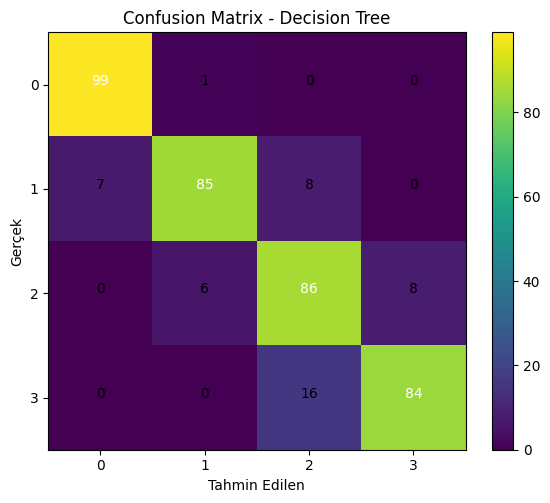

In [40]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_test_pred)
print("[Decision Tree] Confusion Matrix:")
print(cm_dt)

# Confusion Matrix Görselleştirme (SVM ile aynı stil)
plt.figure(figsize=(6, 5))
plt.imshow(cm_dt, interpolation="nearest")
plt.title("Confusion Matrix - Decision Tree")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")

thresh = cm_dt.max() / 2.
for i in range(cm_dt.shape[0]):
    for j in range(cm_dt.shape[1]):
        plt.text(
            j, i, format(cm_dt[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_dt[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

In [46]:
# 3- RANDOM FOREST MODEL
from sklearn.ensemble import RandomForestClassifier

# Random Forest için hiperparametre ızgarası
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 8]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GridSearchCV ile en iyi hiperparametreleri bul
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("\n[Random Forest] En iyi hiperparametreler (GridSearchCV):")
print(grid_rf.best_params_)
print("[Random Forest] En iyi CV skoru (train üzeri 3-fold ortalama):", grid_rf.best_score_)

# En iyi modeli al
best_rf = grid_rf.best_estimator_

# Train ve Test performansı (overfitting kontrolü)
rf_train_pred = best_rf.predict(X_train)
rf_test_pred  = best_rf.predict(X_test)

rf_train_acc = accuracy_score(y_train, rf_train_pred)
rf_test_acc  = accuracy_score(y_test, rf_test_pred)

print("\n[Random Forest] Train accuracy:", rf_train_acc)
print("[Random Forest] Test accuracy:", rf_test_acc)

Fitting 3 folds for each of 54 candidates, totalling 162 fits

[Random Forest] En iyi hiperparametreler (GridSearchCV):
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
[Random Forest] En iyi CV skoru (train üzeri 3-fold ortalama): 0.8660781879652225

[Random Forest] Train accuracy: 0.9974968710888611
[Random Forest] Test accuracy: 0.885


Random Forest modelinin ilk GridSearchCV sonucunda seçilen max_depth=None, min_samples_split=2 ve min_samples_leaf=1 gibi esnek parametreler, modelin eğitim verisini neredeyse tamamen ezberlemesine neden olmuş ve train doğruluğu %100’e ulaşırken test doğruluğu %89 seviyesinde kalmıştır. Bu durum belirgin bir overfitting göstermiştir.

Overfitting’i azaltmak için hiperparametre aralığı daha kısıtlayıcı hale getirilmiş ve ikinci GridSearchCV sonucunda max_depth=10, min_samples_split=5, min_samples_leaf=2 ve n_estimators=200 en iyi kombinasyon olarak belirlenmiştir. Bu ayarlardan sonra train doğruluğu %99.7’ye düşmüş, test doğruluğu ise %88.5 olarak elde edilmiştir. Böylece model daha dengeli ve genellenebilir bir hale gelmiştir.

Parametreler daha da sınırlanarak overfitting azaltılabilir; ancak bu durumda test performansının düşme ihtimali bulunduğundan mevcut sonuçlar Random Forest için makul bir denge sunmaktadır.

In [47]:
# Classification Report (Test verisi)
print("\n[Random Forest] Classification Report (Test verisi):")
print(classification_report(y_test, rf_test_pred))


[Random Forest] Classification Report (Test verisi):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       100
           1       0.83      0.85      0.84       100
           2       0.82      0.78      0.80       100
           3       0.92      0.94      0.93       100

    accuracy                           0.89       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.89      0.88       400



[Random Forest] Confusion Matrix:
[[97  3  0  0]
 [ 4 85 11  0]
 [ 0 14 78  8]
 [ 0  0  6 94]]


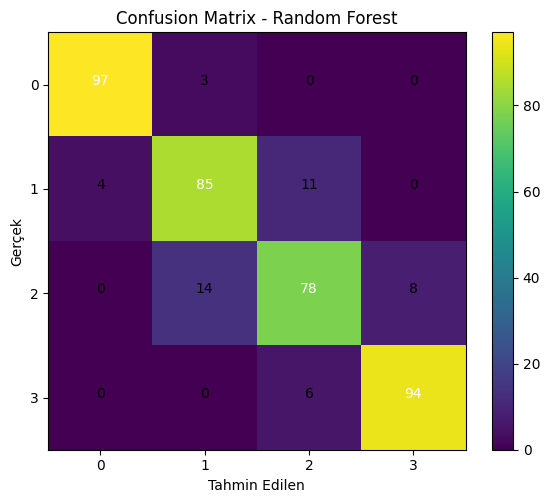

In [48]:
# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_test_pred)
print("[Random Forest] Confusion Matrix:")
print(cm_rf)

# Confusion Matrix Görselleştirme (SVM ve DT ile aynı stil)
plt.figure(figsize=(6, 5))
plt.imshow(cm_rf, interpolation="nearest")
plt.title("Confusion Matrix - Random Forest")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")

thresh = cm_rf.max() / 2.
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(
            j, i, format(cm_rf[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm_rf[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

# Random Forest XAI Shap

c:\Users\furkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


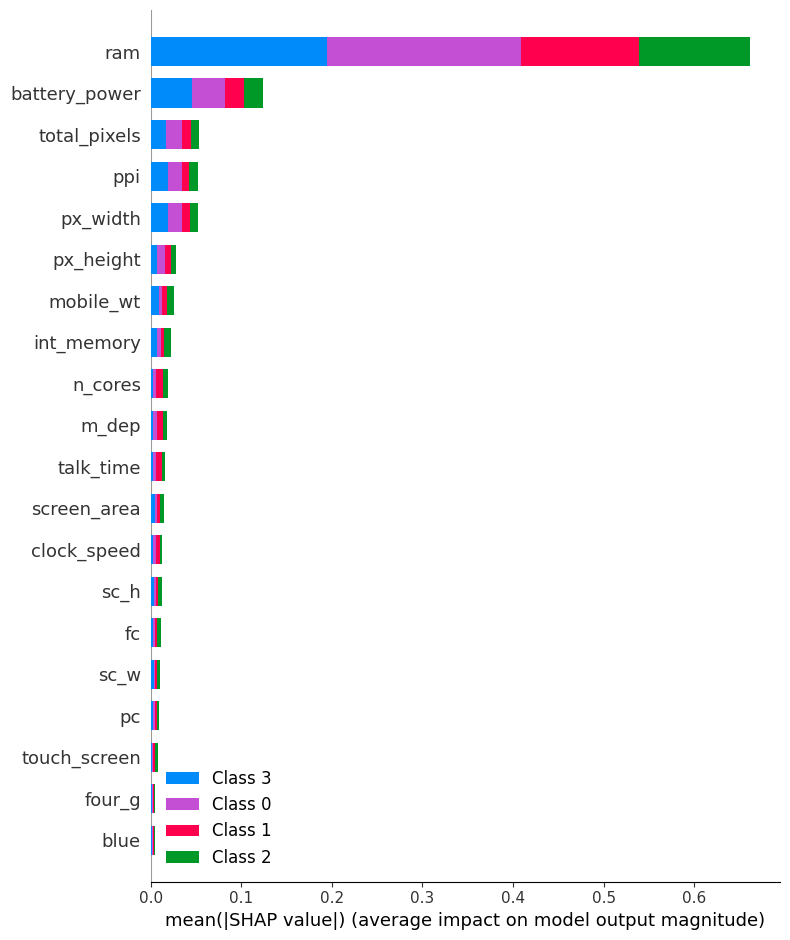

In [49]:
import shap

# Ağaç tabanlı modeller için en hızlı ve uygun explainer
explainer_rf = shap.TreeExplainer(best_rf)

# Test seti için SHAP değerlerini hesaplayalım
# (çok yavaş değil ama istersen X_test'in küçük bir parçasını da kullanabilirsin)
shap_values_rf = explainer_rf.shap_values(X_test)

# Bar tipi özet (feature importance gibi, SHAP tabanlı)
shap.summary_plot(shap_values_rf, X_test, plot_type="bar", show=True)

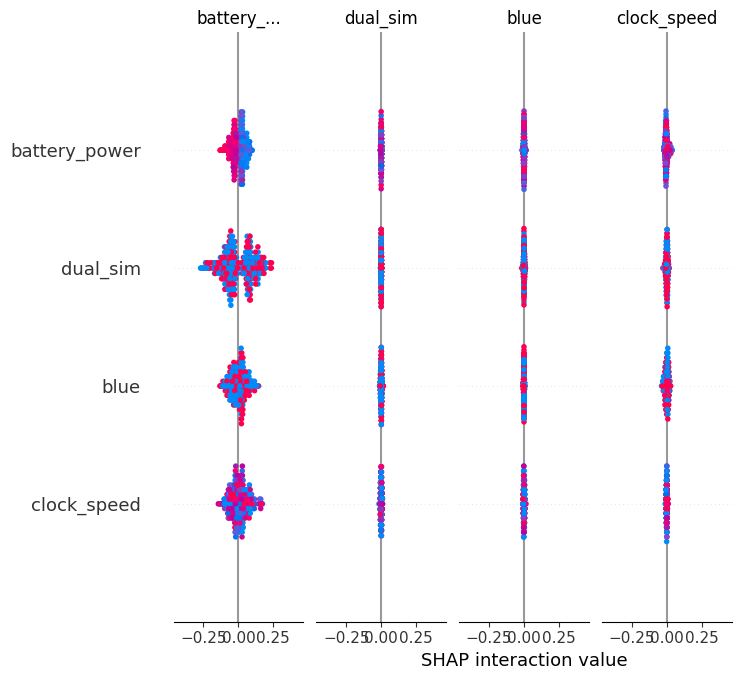

In [50]:
shap.summary_plot(shap_values_rf, X_test, show=True)

In [56]:
# Açıklamak istediğin örnek (i. index)
i = 0
sample = X_test.iloc[[i]]  # DataFrame olarak kalması için çift köşeli

# SHAP değerleri (tek örnek için)
sample_shap_values = explainer_rf.shap_values(sample)

print("sample_shap_values type:", type(sample_shap_values))

# Gerçek ve tahmin edilen sınıf
print("Gerçek sınıf:", y_test.iloc[i])
pred_class = int(best_rf.predict(sample)[0])
print("Tahmin edilen sınıf:", pred_class)

# 1) Eğer shap_values LISTE ise (klasik çok sınıflı çıktı):
if isinstance(sample_shap_values, list):
    values = sample_shap_values[pred_class][0]           # (n_features,)
    base_value = explainer_rf.expected_value[pred_class] # scalar
else:
    # 2) Eğer TEK ARRAY ise → class bazlı ayrım yok, doğrudan ilk satırı al
    values = sample_shap_values[0]                       # (n_features,)
    base_value = explainer_rf.expected_value             # scalar

data_row = sample.iloc[0]

# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=values,
        base_values=base_value,
        data=data_row,
        feature_names=sample.columns
    )
)

# Force plot (alternatif, istersen)
shap.force_plot(
    base_value,
    values,
    data_row,
    matplotlib=True
)


sample_shap_values type: <class 'numpy.ndarray'>
Gerçek sınıf: 3
Tahmin edilen sınıf: 3


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (23, 4)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.